In [3]:
import matplotlib.pyplot as plt
import os
import importlib
import pandas

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
import common_utils
importlib.reload(common_utils)
from common_utils import *
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping



In [5]:

image_paths_csv = pd.read_csv("./processed_data/image_paths_7_classes.csv")
#aug data
image_paths_csv_aug = pd.read_csv("./processed_data/image_paths_7_classes_aug.csv")

# bloack for training
train_block_1, val_block_1, train_block_2, val_block_2, test_block=split_blocks(image_paths_csv)

In [3]:
len(train_block_1), len(train_block_2), len(val_block_1), len(val_block_2), len(test_block)

(3445, 3446, 862, 862, 957)

In [4]:
test_block.age_bin.value_counts()

age_bin
0    205
3    184
4    177
5    129
2    100
1     94
6     68
Name: count, dtype: int64

In [6]:
train_block_1_aug=add_augmentations(train_block_1)
train_block_2_aug=add_augmentations(train_block_2)

In [6]:
train_block_2_aug.head()

,path,age,age_bin,age_bin_label,base_name
0,../raw_data2/face_age/001/1030_rot20.png,1,0,Infant/Toddler (1–4),1030
0,../raw_data2/face_age/001/1030_rot40.png,1,0,Infant/Toddler (1–4),1030
0,../raw_data2/face_age/001/1030_rot-20.png,1,0,Infant/Toddler (1–4),1030
0,../raw_data2/face_age/001/1030_rot-40.png,1,0,Infant/Toddler (1–4),1030
0,../raw_data2/face_age/001/1030_mirror.png,1,0,Infant/Toddler (1–4),1030


In [49]:
# normal data
batch_size=32
train_block_1_dataset_aug = load_images_from_paths(paths_tensor=tf.constant(list(train_block_1_aug['path'])),batch_size=batch_size,task="autoencoder",resize=192)

train_block_1_dataset_raw = load_images_from_paths(paths_tensor=tf.constant(list(train_block_1['path'])),batch_size=batch_size,task="autoencoder",resize=192)

val_block_1_dataset= load_images_from_paths(paths_tensor=tf.constant(list(val_block_1['path'])),batch_size=batch_size,task="autoencoder",resize=192)

train_block_2_dataset_aug = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_2_aug['path'])),
    target_tensor=tf.constant(list(train_block_2_aug['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)

train_block_2_dataset_raw = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_2['path'])),
    target_tensor=tf.constant(list(train_block_2['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)


val_block_2_dataset= load_images_from_paths(
    paths_tensor=tf.constant(list(val_block_2['path'])),
    target_tensor=tf.constant(list(val_block_2['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)

test_block_dataset_autoencoder=load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    batch_size=batch_size,task="autoencoder",resize=192
)

test_block_dataset = load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    target_tensor=tf.constant(list(test_block['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)



In [80]:

    # {"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,"aug_data":True,"use_skip":True},
configs=[
    {"name": "B2B_deep_bn_reg_aug_autoencoder","epochs":500, "l2_reg": 0,"batch_size":batch_size,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": False, "aug_data": True,
     "task":"autoencoder","resize":192},
]


default_args = {
    "batch_size": 32,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "regression",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    
        cfg_full = {**default_args, **cfg}
        cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
        cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
        
        model = build_autoencoder(
                input_shape=(192, 192, cfg_full["channels"]),
                conv_filters=cfg_full["conv_filters"],
                kernel_size=cfg_full["kernel_size"],
                activation=cfg_full["activation"],
                batch_norm=cfg_full["batch_norm"],
                l2_reg=cfg_full["l2_reg"],
        )
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse',"accuracy"])
        cfg_full["model"] = model
        
        model_list.append(cfg_full)


In [81]:
config_count=3

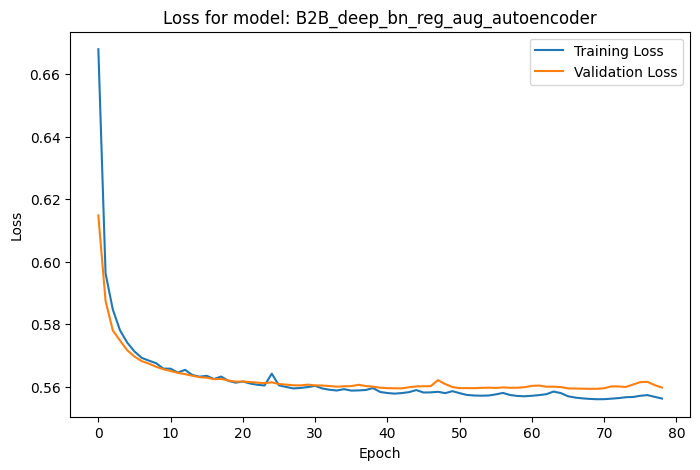

108/108 [==============================] - 2s 18ms/step - loss: 0.5562 - mse: 0.0024 - accuracy: 0.9478 - val_loss: 0.5597 - val_mse: 0.0040 - val_accuracy: 0.9466


In [82]:
os.makedirs(f"autoencoder_saved_models_config_{config_count}",exist_ok=True)
for entry in model_list:
    model_name= entry["name"]
    checkpoint_path = f"autoencoder_saved_models_config_{config_count}/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    callbacks = [checkpoint]


    early_stop_loss = DelayedEarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=60  # begin checks after 60 epochs
    )
    
    callbacks.append(early_stop_loss)
    
    callbacks.append(LiveLossPlot(model_name=model_name))

    history = entry["model"].fit(
        train_block_1_dataset_raw,
        validation_data=val_block_1_dataset,
        epochs=entry["epochs"],
        batch_size=entry["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    entry["history"] = history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"autoencoder_model_summary_config_{config_count}.csv", index=False)


In [47]:
from tensorflow.keras.models import load_model

model=load_model(f"autoencoder_saved_models_config_{config_count}/B2B_deep_bn_reg_aug_autoencoder_best_model.keras")

In [51]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 batch_normalization_50 (Ba  (None, 192, 192, 32)      128       
 tchNormalization)                                               
                                                                 
 average_pooling2d_25 (Aver  (None, 96, 96, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_26 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_51 (Ba  (None, 96, 96, 64)        256 

In [50]:
loss = model.evaluate(test_block_dataset_autoencoder)
print(f"Validation loss: {loss}")


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [74]:
import matplotlib.pyplot as plt

# Get one batch from the dataset
for batch in val_block_1_dataset.take(50):
    x_true = batch[0]  # assuming (x, y) format
    break

# Get reconstructions
x_pred = model.predict(x_true)


1/1 [==============================] - 0s 81ms/step


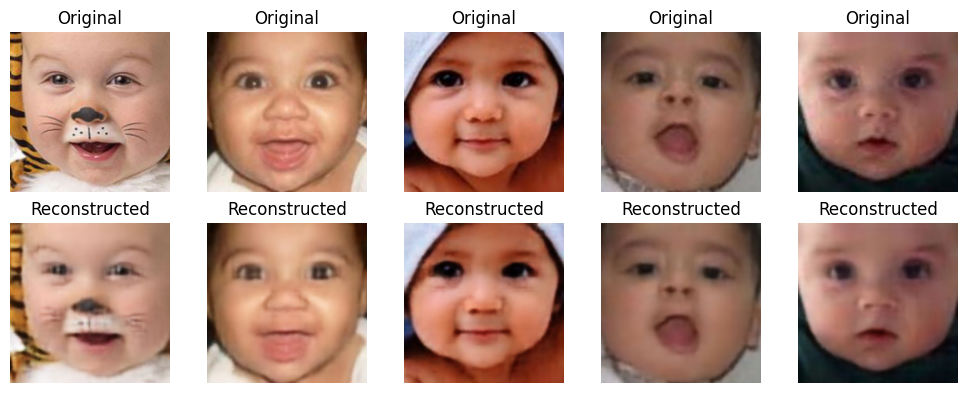

In [75]:
def plot_reconstructions(x_true, x_pred, n=50):
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(x_true[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(x_pred[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_reconstructions(x_true.numpy(), x_pred, n=5)


In [62]:
def get_image_by_index(dataset, index):
    for i, batch in enumerate(dataset):
        x = batch[0]  # assume (x, y) format
        if index < len(x):
            return x[index]
        index -= len(x)  # subtract batch size and continue
    raise IndexError("Index out of range")


In [65]:
img = get_image_by_index(val_block_1_dataset, 202)  # get 18th image
img = tf.expand_dims(img, axis=0)  # add batch dimension for prediction


1/1 [==============================] - 0s 118ms/step


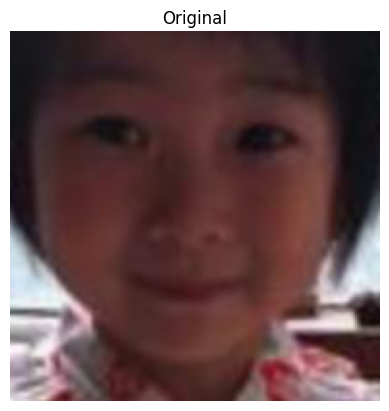

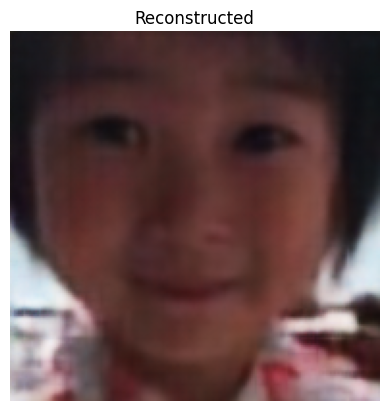

In [76]:
reconstructed = model.predict(img)

plt.imshow(img[0])
plt.title("Original")
plt.axis("off")
plt.show()

plt.imshow(reconstructed[0])
plt.title("Reconstructed")
plt.axis("off")
plt.show()


In [8]:
# Get the encoder up to the 'encoded' layer
encoder_frozen = models.Model(inputs=model.input, outputs=model.get_layer('encoded').output)
encoder_frozen.trainable = False

encoder_non_frozen = models.Model(inputs=model.input, outputs=model.get_layer('encoded').output)


In [9]:
configs=[
    {"name": "B2B_deep_bn_reg_aug_transfer_frozen","epochs":500, "l2_reg": 1e-4,"batch_size":256,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": True, "aug_data": True,
     "task":"classification","resize":192},

    {"name": "B2B_deep_bn_reg_aug_transfer_non_frozen","epochs":500, "l2_reg": 1e-4,"batch_size":256,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": True, "aug_data": True,
     "task":"classification","resize":192},
]


default_args = {
    "batch_size": 512,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    cfg_full = {**default_args, **cfg}
    cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
    cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
    
    if "non_frozen" in cfg_full["name"]:
        model = build_transfer_model_from_autoencoder(encoder_non_frozen, cfg_full,num_classes=7)
    else:
        model = build_transfer_model_from_autoencoder(encoder_frozen, cfg_full,num_classes=7)
        
    model.compile(optimizer='adam', loss=cfg_full["loss"], metrics=cfg_full["metrics"])
    cfg_full["model"] = model
    
    model_list.append(cfg_full)


In [10]:
model_list[0]['model'].summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 192, 192, 32)      128       
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 96, 96, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 96, 96, 64)        256 

config_count=0

In [12]:
config_count=0

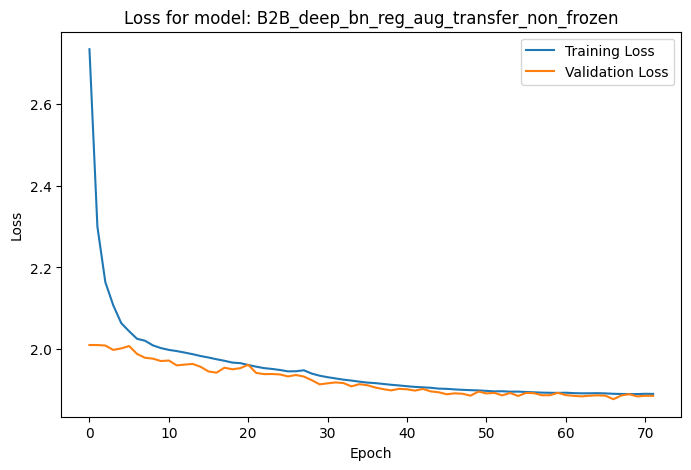

68/68 [==============================] - 9s 139ms/step - loss: 1.8912 - accuracy: 0.1942 - val_loss: 1.8865 - val_accuracy: 0.1914


In [13]:
os.makedirs(f"transfer_saved_models_config_{config_count}",exist_ok=True)
for entry in model_list:
    model_name= entry["name"]
    checkpoint_path = f"transfer_saved_models_config_{config_count}/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    callbacks = [checkpoint]

    early_stop_loss = DelayedEarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=60  # begin checks after 60 epochs
    )
    
    callbacks.append(early_stop_loss)
    
    callbacks.append(LiveLossPlot(model_name=model_name))

    history = entry["model"].fit(
        train_block_2_dataset,
        validation_data=val_block_2_dataset,
        epochs=entry["epochs"],
        batch_size=entry["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    entry["history"] = history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"transfer_model_summary_config_{config_count}.csv", index=False)


In [20]:
model_list[0]['history'].history['loss']

[2.751330852508545,
 2.298975706100464,
 2.1696228981018066,
 2.1105244159698486,
 2.074249505996704,
 2.0463521480560303,
 2.032604455947876,
 2.0203840732574463,
 2.011411190032959,
 2.006572723388672,
 2.0008130073547363,
 1.9981400966644287,
 1.9931644201278687,
 1.9879976511001587,
 1.9852795600891113,
 1.9814261198043823,
 1.977278470993042,
 1.9746747016906738,
 1.970177173614502,
 1.9661593437194824,
 1.9633461236953735,
 1.9600932598114014,
 1.9552828073501587,
 1.9527069330215454,
 1.9506824016571045,
 1.9469249248504639,
 1.9432847499847412,
 1.9404637813568115,
 1.939067006111145,
 1.9348338842391968,
 1.933454990386963,
 1.9323108196258545,
 1.9318081140518188,
 1.935370683670044,
 1.9270020723342896,
 1.9232674837112427,
 1.9194754362106323,
 1.9172645807266235,
 1.9156438112258911,
 1.9133116006851196,
 1.9118767976760864,
 1.9101653099060059,
 1.909739375114441,
 1.9072990417480469,
 1.9066646099090576,
 1.9049924612045288,
 1.904009222984314,
 1.9026949405670166,
 1.90

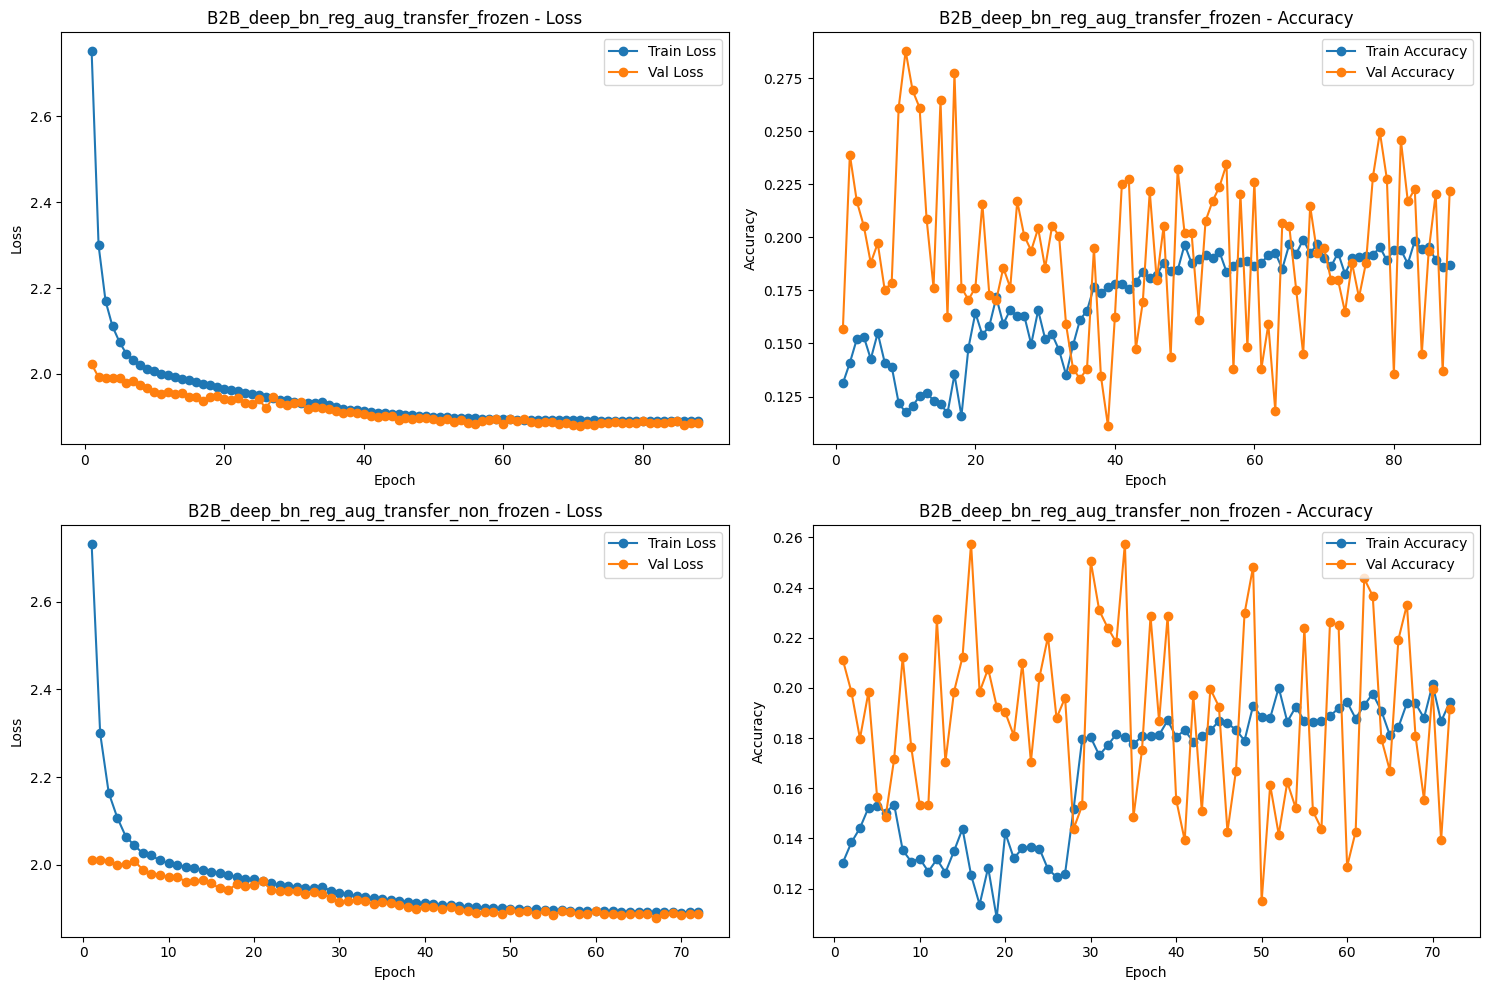

In [21]:

# Create subplots: one row per model, two columns (loss and accuracy)

fig, axes = plt.subplots(nrows=len(model_list), ncols=2, figsize=(15, 5 * len(model_list)))

# Ensure axes is always 2D
if len(model_list) == 1:
    axes = np.array([axes])

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    try:
        model_name = entry["name"]
        history = entry["history"].history
        epochs = list(range(1, len(history["loss"]) + 1))

        # Loss Plot
        ax_loss = axes[i, 0]
        ax_loss.plot(epochs, history["loss"], label='Train Loss', marker='o')
        ax_loss.plot(epochs, history["val_loss"], label='Val Loss', marker='o')
        ax_loss.set_title(f"{model_name} - Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()

        # Accuracy Plot
        ax_acc = axes[i, 1]
        ax_acc.plot(epochs, history["accuracy"], label='Train Accuracy', marker='o')
        ax_acc.plot(epochs, history["val_accuracy"], label='Val Accuracy', marker='o')
        ax_acc.set_title(f"{model_name} - Accuracy")
        ax_acc.set_xlabel("Epoch")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.legend()
    except Exception:
        continue

plt.tight_layout()
plt.show()

In [ ]:

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    
        model_name = entry["name"]
        best_model_path = f"transfer_saved_models_config_{config_count}/{model_name}_best_model.keras"
        
        test_dataset = test_block_dataset
        # Load the best saved model
        
        model = load_model(best_model_path)
        
        # Evaluate on test set
        model_score = model.evaluate(test_dataset, verbose=1)
        model_labels = model.metrics_names

        print(f"🔍 {model_name} — Evaluation on Test Set:")
        for label, score in zip(model_labels, model_score):
            print(f"   {label}: {round(score, 4)}")
        print("-" * 40)
        y_pred = model.predict(test_dataset)
        y_true = np.concatenate([y for x, y in test_dataset], axis=0)

        # Print predicted vs true values
        print("📋 Predictions vs Ground Truth:")
        for pred, true in zip(y_pred.flatten(), y_true.flatten()):
            print(f"   Predicted: {round(pred, 2)} — Actual: {int(true)}")
        pred_classes = np.argmax(y_pred, axis=1)
        true_classes = np.argmax(y_true, axis=1)

        for pred, true in zip(pred_classes, true_classes):
            print(f"   Predicted: {pred} — Actual: {true}")


    

In [ ]:
configs=[
    {"name": "B2B_deep_bn_reg_aug_transfer_frozen","epochs":500, "l2_reg": 1e-4,"batch_size":256,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": True, "aug_data": True,
     "task":"classification","resize":192},

    {"name": "B2B_deep_bn_reg_aug_transfer_non_frozen","epochs":500, "l2_reg": 1e-4,"batch_size":256,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": True, "aug_data": True,
     "task":"classification","resize":192},
]


default_args = {
    "batch_size": 512,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

cfg_full={**default_args, **configs[0]}

In [ ]:
backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
backbone.trainable = True
model = build_transfer_model_from_autoencoder(backbone, cfg_full,num_classes=7)

os.makedirs(f"backbone_saved_models_config_{config_count}",exist_ok=True)
for entry in cfg_full:
    model_name= entry["name"]
    checkpoint_path = f"backbone_saved_models_config_{config_count}/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    callbacks = [checkpoint]

    early_stop_loss = DelayedEarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=60  # begin checks after 60 epochs
    )
    
    callbacks.append(early_stop_loss)
    
    callbacks.append(LiveLossPlot(model_name=model_name))

    history = entry["model"].fit(
        train_block_1_dataset,
        validation_data=val_block_1_dataset,
        epochs=entry["epochs"],
        batch_size=entry["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    entry["history"] = history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"backbone_model_summary_config_{config_count}.csv", index=False)
